# la Classification des Maladies Végétales avec le Dataset PlantVillage

**Pommes**: Images de feuilles de pommiers affectees par diverses maladies,
avec les classes suivantes :
* Apple scab (tavelure du pommier)

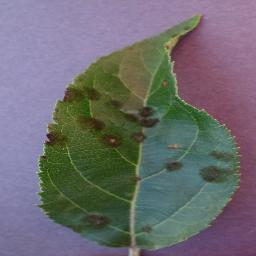

*  Black rot (pourriture noire)

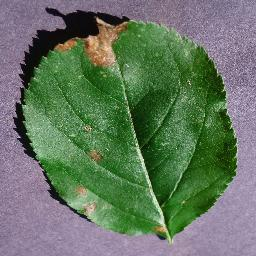

* Cedar apple rust (rouille grillag´ee du pommier)

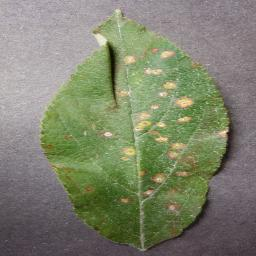

* Echantillons de feuilles saines

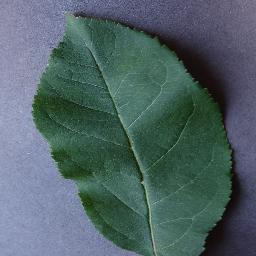

**Importing necessary libraries**

In [1]:
pip install imagehash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 5.5 MB/s eta 0:00:00


In [2]:
pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 2.2 MB/s eta 0:00:00


In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hashlib
import seaborn as sns
import cv2
import tensorflow_datasets as tfds
from PIL import Image
import imagehash
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_auc_score,roc_curve
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3

# Exploratory Data Analysis

In [4]:
# Load PlantVillage dataset using the builder
builder = tfds.builder("plant_village")
info = builder.info

In [ ]:
# Display information about the dataset
print(info)

tfds.core.DatasetInfo(
    name='plant_village',
    full_name='plant_village/1.0.2',
    description="""
    The PlantVillage dataset consists of 54303 healthy and unhealthy leaf images
    divided into 38 categories by species and disease.
    
    NOTE: The original dataset is not available from the original source
    (plantvillage.org), therefore we get the unaugmented dataset from a paper that
    used that dataset and republished it. Moreover, we dropped images with
    Background_without_leaves label, because these were not present in the original
    dataset.
    
    Original paper URL: https://arxiv.org/abs/1511.08060 Dataset URL:
    https://data.mendeley.com/datasets/tywbtsjrjv/1
    """,
    homepage='https://arxiv.org/abs/1511.08060',
    data_dir=PosixGPath('/tmp/tmpdanryjwntfds'),
    file_format=tfrecord,
    download_size=827.82 MiB,
    dataset_size=815.37 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/fil

In [5]:
# Download and prepare the dataset
builder.download_and_prepare()
ds_train = builder.as_dataset(split="train", as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/54303 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/1.0.2.incompleteUDPMH8/plant_village-train.tfrecord*...:   0…

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


In [6]:
# Specify the classes related to apples
apple_classes = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']

# Filter the dataset to only include examples related to apples
class_indices = [info.features["label"].str2int(class_name) for class_name in apple_classes]
dfx = ds_train.filter(lambda image, label: tf.reduce_any(tf.equal(label, class_indices)))
dfx

<_FilterDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
# Create a list of dictionaries
data_list = []
for example in dfx:
    image, label = example
    # Convert image matrix to actual image
    image = tf.image.convert_image_dtype(image, tf.uint8)
    # Map label index to class name
    class_name = info.features["label"].int2str(label.numpy())
    data_list.append({'image': image.numpy(), 'label': class_name})

# Convert the list to a pandas DataFrame
df = pd.DataFrame(data_list)

# Display the DataFrame
print(df.head())

                                               image                     label
0  [[[96, 98, 121], [114, 116, 139], [99, 101, 12...           Apple___healthy
1  [[[173, 169, 160], [170, 166, 157], [166, 162,...  Apple___Cedar_apple_rust
2  [[[139, 130, 159], [118, 109, 138], [122, 113,...        Apple___Apple_scab
3  [[[209, 197, 197], [207, 195, 195], [154, 142,...         Apple___Black_rot
4  [[[148, 136, 136], [154, 142, 142], [165, 153,...         Apple___Black_rot


In [ ]:
#!rm -rf /content/apple

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3171 entries, 0 to 3170
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   3171 non-null   object
 1   label   3171 non-null   object
dtypes: object(2)
memory usage: 49.7+ KB


In [ ]:
# Map numeric labels to class names
df["label"].value_counts()

Apple___healthy             1645
Apple___Apple_scab           630
Apple___Black_rot            621
Apple___Cedar_apple_rust     275
Name: label, dtype: int64

In [ ]:
df.head()

image                     label
0  [[[96, 98, 121], [114, 116, 139], [99, 101, 12...           Apple___healthy
1  [[[173, 169, 160], [170, 166, 157], [166, 162,...  Apple___Cedar_apple_rust
2  [[[139, 130, 159], [118, 109, 138], [122, 113,...        Apple___Apple_scab
3  [[[209, 197, 197], [207, 195, 195], [154, 142,...         Apple___Black_rot
4  [[[148, 136, 136], [154, 142, 142], [165, 153,...         Apple___Black_rot

In [ ]:
df.tail()

image              label
3166  [[[145, 133, 133], [147, 135, 135], [185, 173,...  Apple___Black_rot
3167  [[[172, 161, 167], [160, 149, 155], [154, 143,...  Apple___Black_rot
3168  [[[165, 166, 186], [163, 164, 184], [161, 162,...    Apple___healthy
3169  [[[88, 77, 91], [90, 79, 93], [93, 82, 96], [1...    Apple___healthy
3170  [[[120, 125, 147], [115, 120, 142], [115, 120,...    Apple___healthy

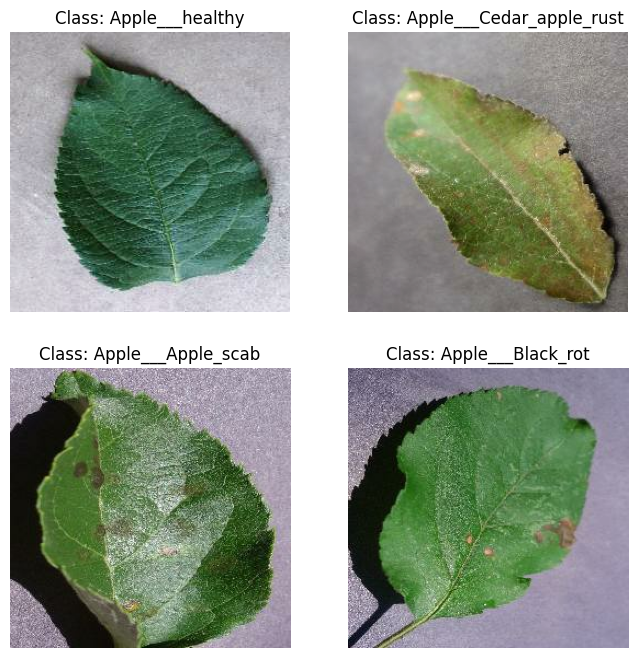

In [ ]:
# Display sample images from each class
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for class_name, ax in zip(df['label'].unique(), axes.flatten()):
    # Get a random image from the class
    sample_img = df[df['label'] == class_name].sample(1)['image'].values[0]
    img = tf.keras.preprocessing.image.array_to_img(sample_img)
    ax.imshow(img)
    ax.set_title(f"Class: {class_name}")
    ax.axis("off")

plt.show()


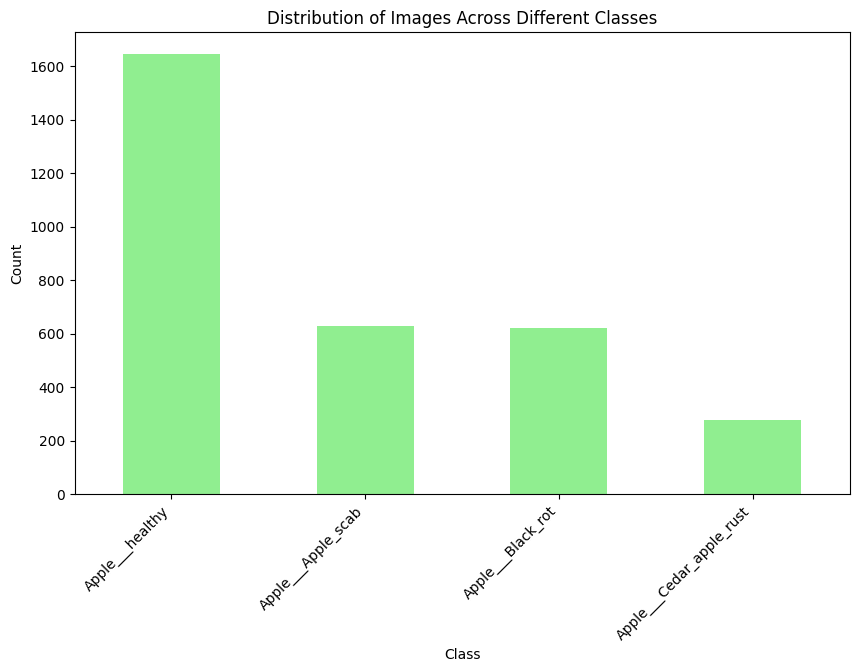

In [ ]:
# Plot the distribution of images across different classes
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Distribution of Images Across Different Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

Duplicate Entries:
                  label              hash
723     Apple___healthy  fff3c3030303071f
885     Apple___healthy  ffd3cdc18080c1c3
1385    Apple___healthy  ffe1c181030387cf
1604    Apple___healthy  f9e1c1818183c7ff
1721    Apple___healthy  83c7c7838383c3ff
1796    Apple___healthy  cfc783818181c7ff
1810    Apple___healthy  fff1e0c08080c1ff
1929    Apple___healthy  f9f0c0c0c181c7ff
2021    Apple___healthy  ffc381810181c3ff
2298    Apple___healthy  d9c1c18183d3dfff
2431    Apple___healthy  fff9e1c181818183
2771    Apple___healthy  fff8e0c0c08183ff
3036  Apple___Black_rot  e7c1818181c3ffff
3079    Apple___healthy  fff1e1c1c1c1873f


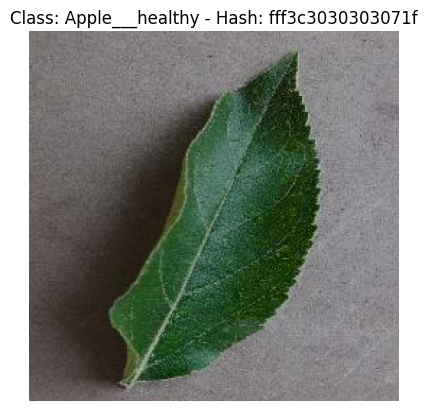

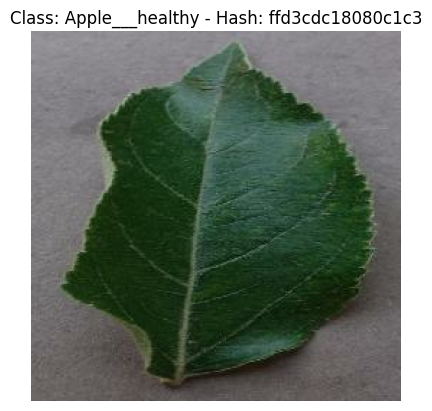

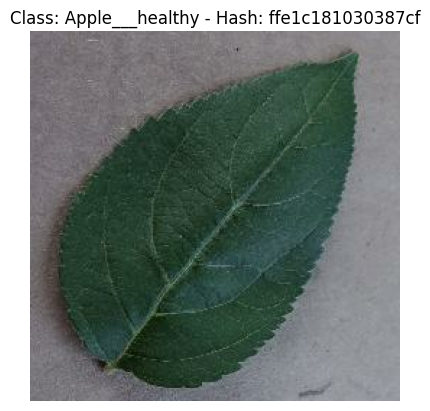

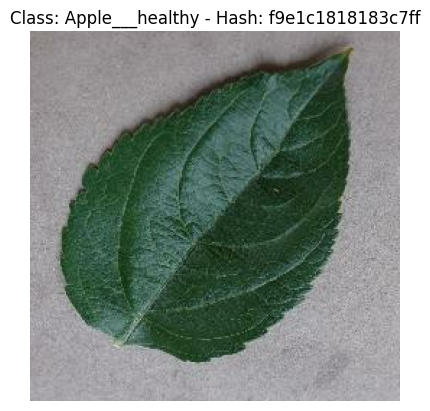

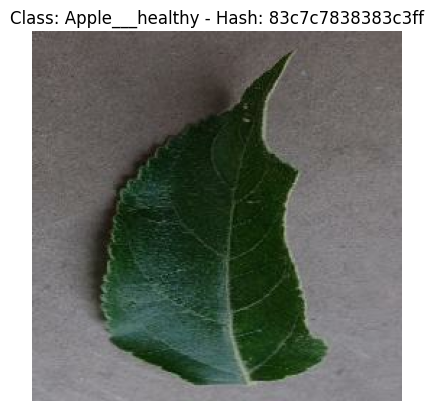

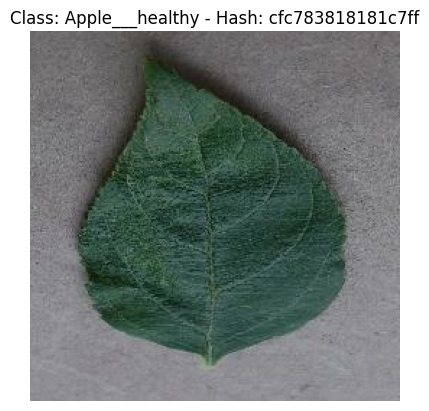

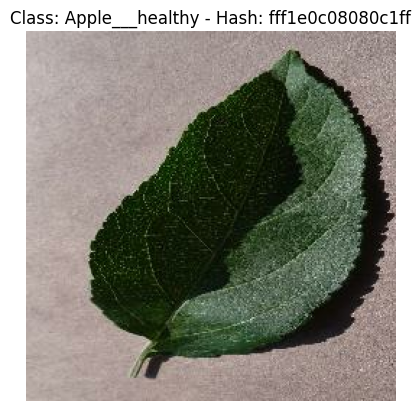

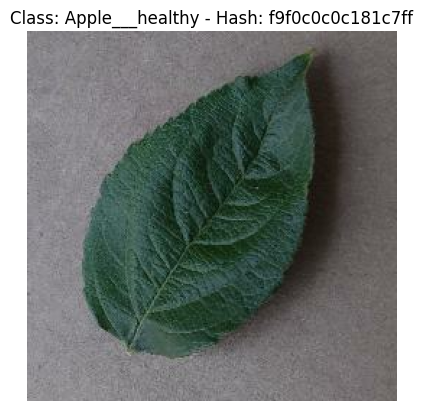

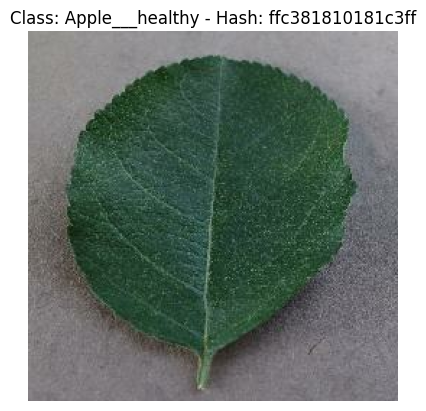

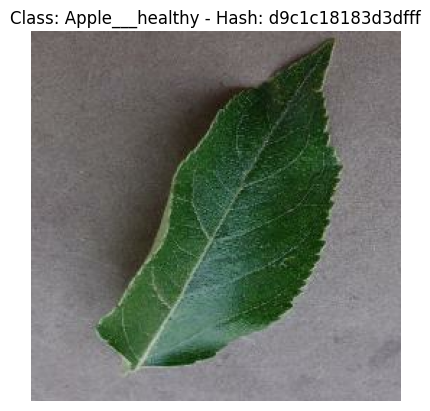

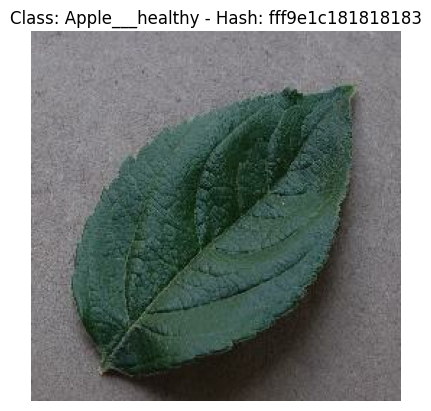

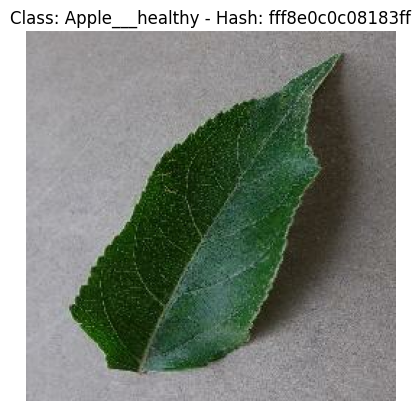

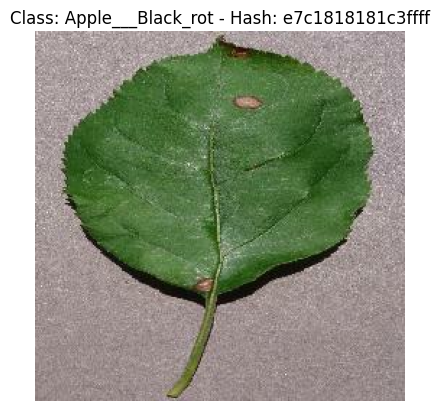

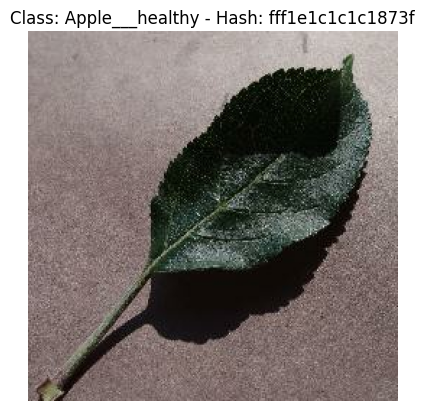

In [ ]:
# Function to compute hash for each image
def compute_hash(img_array):
    img = Image.fromarray(img_array)
    return str(imagehash.average_hash(img))
df['hash'] = df['image'].apply(compute_hash)

# Check for duplicate hashes
duplicates = df[df.duplicated(subset='hash')]

# Display duplicate entries
print("Duplicate Entries:")
print(duplicates[['label', 'hash']])

# Display the duplicate images
for _, duplicate in duplicates.iterrows():
    img = Image.fromarray(duplicate['image'])
    plt.imshow(img)
    plt.title(f"Class: {duplicate['label']} - Hash: {duplicate['hash']}")
    plt.axis("off")
    plt.show()


In [ ]:
# Function to compute image statistics
def compute_image_statistics(img_array):
    height, width, channels = img_array.shape
    # Compute mean and standard deviation of pixel values for each channel
    channel_means = np.mean(img_array, axis=(0, 1))
    channel_stds = np.std(img_array, axis=(0, 1))
    return {
        'height': height,
        'width': width,
        'channels': channels,
        'mean_R': channel_means[0],
        'mean_G': channel_means[1],
        'mean_B': channel_means[2],
        'std_R': channel_stds[0],
        'std_G': channel_stds[1],
        'std_B': channel_stds[2],
    }

# Apply the function to compute statistics for each image
image_statistics = df['image'].apply(compute_image_statistics)
df_statistics = pd.DataFrame(list(image_statistics))
# Display the computed image statistics
print("Image Statistics:")
print(df_statistics.describe())

Image Statistics:
       height   width  channels       mean_R       mean_G       mean_B  \
count  3171.0  3171.0    3171.0  3171.000000  3171.000000  3171.000000   
mean    256.0   256.0       3.0   109.793696   118.684641   111.149721   
std       0.0     0.0       0.0    17.980062    16.718084    18.587654   
min     256.0   256.0       3.0    48.097122    58.807861    57.583572   
25%     256.0   256.0       3.0    96.973473   106.265335    97.497498   
50%     256.0   256.0       3.0   109.719025   119.176224   109.946503   
75%     256.0   256.0       3.0   120.803528   129.403366   123.235016   
max     256.0   256.0       3.0   193.713959   188.103668   182.300446   

             std_R        std_G        std_B  
count  3171.000000  3171.000000  3171.000000  
mean     46.080925    39.344726    51.420544  
std      10.797594    10.323347    10.053840  
min      14.292669    11.854616    16.996847  
25%      38.973054    32.384882    44.553945  
50%      45.947421    39.203361  

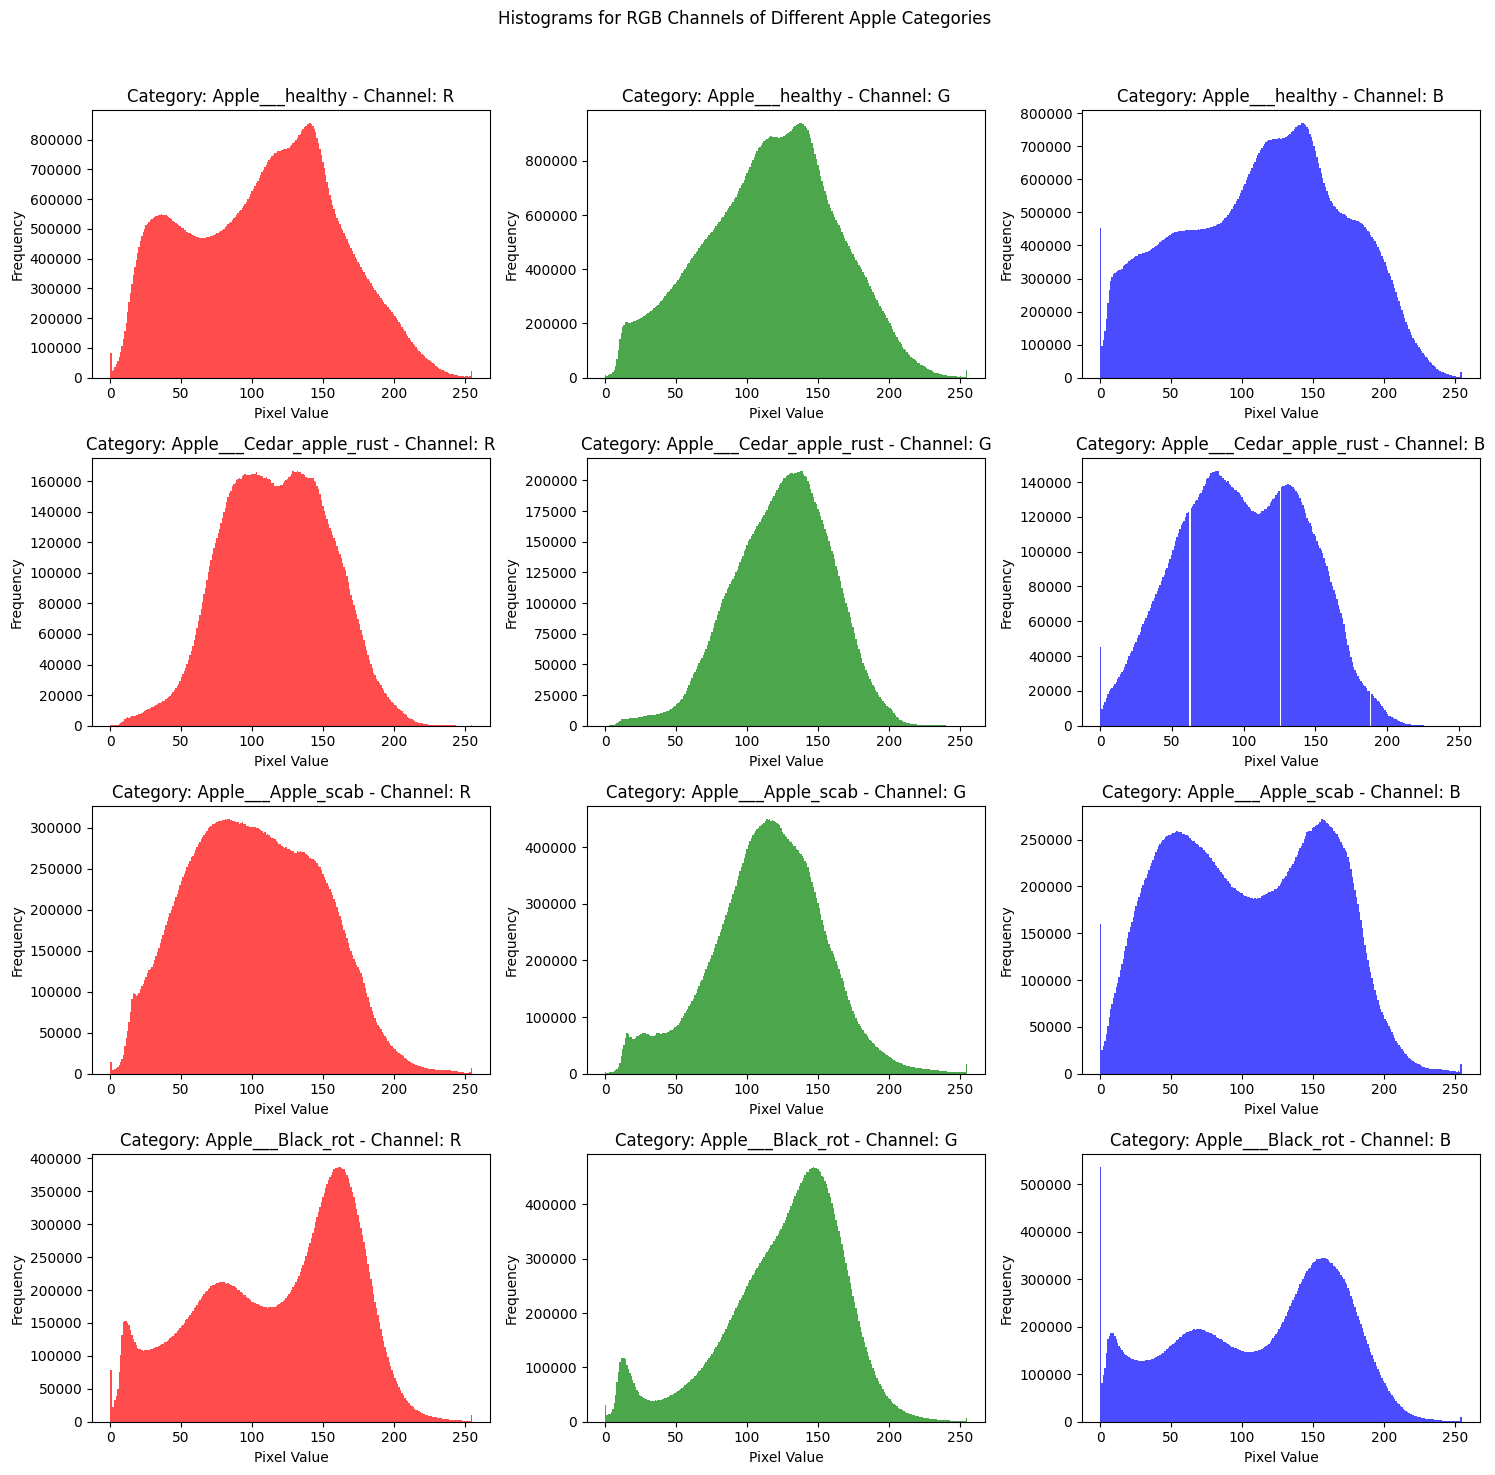

In [ ]:
# Function to plot histograms for each RGB channel
def plot_rgb_histograms(images, labels):
    fig, axes = plt.subplots(4, 3, figsize=(15, 15))
    fig.suptitle('Histograms for RGB Channels of Different Apple Categories')

    categories = labels.unique()

    for i, category in enumerate(categories):
        category_images = images[labels == category]

        for j, channel in enumerate(['R', 'G', 'B']):
            axes[i, j].hist(category_images[:, :, :, j].flatten(), bins=256, color=channel.lower(), alpha=0.7)
            axes[i, j].set_title(f'Category: {category} - Channel: {channel}')
            axes[i, j].set_xlabel('Pixel Value')
            axes[i, j].set_ylabel('Frequency')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot histograms for each RGB channel
plot_rgb_histograms(np.stack(df['image']), df['label'])


# Prétraitement des Images

In [8]:
def normalize_image(image):
    return image / 255.0

In [9]:
# Function to perform histogram equalization on an image
def histogram_equalization(image):
    # Separate the image into color channels
    b, g, r = cv2.split(image)
    # Apply histogram equalization to each channel
    b_equalized = cv2.equalizeHist(b)
    g_equalized = cv2.equalizeHist(g)
    r_equalized = cv2.equalizeHist(r)
    # Merge the equalized channels back into an RGB image
    equalized_image = cv2.merge([b_equalized, g_equalized, r_equalized])
    normalized = normalize_image(equalized_image)
    return normalized
# Apply histogram equalization to each image in the DataFrame
df['equalized_image'] = df['image'].apply(histogram_equalization)

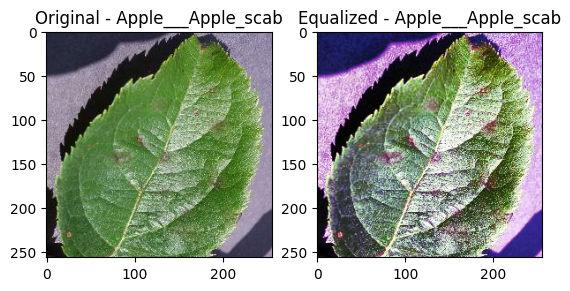

In [10]:
#  Display original and equalized images for a specific row
row_index = 8
original_image = df.loc[row_index, 'image']
equalized_image = df.loc[row_index, 'equalized_image']
label = df.loc[row_index, 'label']

# Display original and equalized images
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original - ' + label)

plt.subplot(1, 2, 2)
plt.imshow(equalized_image)
plt.title('Equalized - ' + label)

plt.show()

# Modéles de Deep Learning pour la Computer Vision

In [11]:
# Convert labels to numerical format
label_mapping = {label: i for i, label in enumerate(df['label'].unique())}
df['label_numeric'] = df['label'].map(label_mapping)
df

image  \
0     [[[96, 98, 121], [114, 116, 139], [99, 101, 12...   
1     [[[173, 169, 160], [170, 166, 157], [166, 162,...   
2     [[[139, 130, 159], [118, 109, 138], [122, 113,...   
3     [[[209, 197, 197], [207, 195, 195], [154, 142,...   
4     [[[148, 136, 136], [154, 142, 142], [165, 153,...   
...                                                 ...   
3166  [[[145, 133, 133], [147, 135, 135], [185, 173,...   
3167  [[[172, 161, 167], [160, 149, 155], [154, 143,...   
3168  [[[165, 166, 186], [163, 164, 184], [161, 162,...   
3169  [[[88, 77, 91], [90, 79, 93], [93, 82, 96], [1...   
3170  [[[120, 125, 147], [115, 120, 142], [115, 120,...   

                         label  \
0              Apple___healthy   
1     Apple___Cedar_apple_rust   
2           Apple___Apple_scab   
3            Apple___Black_rot   
4            Apple___Black_rot   
...                        ...   
3166         Apple___Black_rot   
3167         Apple___Black_rot   
3168           Apple___healthy   
3169           Apple___healthy   
3170           Apple___healthy   

                                        equalized_image  label_numeric  
0     [[[0.34509803921568627, 0.19607843137254902, 0...              0  
1     [[[0.996078431372549, 0.996078431372549, 1.0],...              1  
2     [[[0.9019607843137255, 0.8431372549019608, 0.8...              2  
3     [[[0.996078431372549, 0.996078431372549, 0.996...              3  
4     [[[0.6509803921568628, 0.6470588235294118, 0.6...              3  
...                                                 ...            ...  
3166  [[[0.4745098039215686, 0.43137254901960786, 0....              3  
3167  [[[0.8666666666666667, 0.8705882352941177, 0.9...              3  
3168  [[[0.9372549019607843, 0.9607843137254902, 0.9...              0  
3169  [[[0.3254901960784314, 0.2549019607843137, 0.3...              0  
3170  [[[0.6705882352941176, 0.6313725490196078, 0.6...              0  

[3171 rows x 4 columns]

In [12]:
# Split the dataset into training and validation sets
train_data, valid_data = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
train_data

image               label  \
2597  [[[147, 145, 156], [150, 148, 159], [150, 148,...     Apple___healthy   
809   [[[142, 131, 148], [152, 141, 158], [144, 133,...   Apple___Black_rot   
2498  [[[123, 121, 135], [123, 121, 135], [124, 122,...     Apple___healthy   
3014  [[[120, 112, 127], [136, 128, 143], [153, 145,...  Apple___Apple_scab   
2244  [[[178, 172, 206], [172, 166, 200], [172, 166,...     Apple___healthy   
...                                                 ...                 ...   
3092  [[[92, 81, 98], [143, 132, 149], [67, 56, 73],...   Apple___Black_rot   
1095  [[[194, 182, 204], [195, 183, 205], [194, 182,...  Apple___Apple_scab   
1130  [[[193, 190, 201], [194, 191, 202], [189, 186,...     Apple___healthy   
1294  [[[104, 106, 155], [104, 106, 155], [103, 105,...  Apple___Apple_scab   
860   [[[203, 197, 209], [203, 197, 209], [202, 196,...     Apple___healthy   

                                        equalized_image  label_numeric  
2597  [[[0.6666666666666666, 0.4588235294117647, 0.6...              0  
809   [[[0.7215686274509804, 0.5882352941176471, 0.6...              3  
2498  [[[0.49019607843137253, 0.38823529411764707, 0...              0  
3014  [[[0.7058823529411765, 0.6313725490196078, 0.7...              2  
2244  [[[0.996078431372549, 0.996078431372549, 1.0],...              0  
...                                                 ...            ...  
3092  [[[0.21176470588235294, 0.1411764705882353, 0....              3  
1095  [[[0.9686274509803922, 0.9372549019607843, 0.9...              2  
1130  [[[0.9568627450980393, 0.9529411764705882, 0.9...              0  
1294  [[[0.6941176470588235, 0.5529411764705883, 0.7...              2  
860   [[[0.8470588235294118, 0.8352941176470589, 0.8...              0  

[2536 rows x 4 columns]

## 1-ResNet50

In [ ]:
# Load ResNet50 model pre-trained on ImageNet data
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(label_mapping), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [ ]:
# Create data generators
batch_size = 32

train_generator = tf.data.Dataset.from_tensor_slices(
    (np.array(train_data['image'].values.tolist()), train_data['label_numeric'].values)
)
train_generator = train_generator.shuffle(len(train_data)).batch(batch_size)

valid_generator = tf.data.Dataset.from_tensor_slices(
    (np.array(valid_data['image'].values.tolist()), valid_data['label_numeric'].values)
)
valid_generator = valid_generator.batch(batch_size)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=valid_generator
)

Epoch 1/5
80/80 [==============================] - 33s 201ms/step - loss: 0.4469 - accuracy: 0.9050 - val_loss: 0.0614 - val_accuracy: 0.9827
Epoch 2/5
80/80 [==============================] - 12s 145ms/step - loss: 0.0392 - accuracy: 0.9917 - val_loss: 0.0647 - val_accuracy: 0.9780
Epoch 3/5
80/80 [==============================] - 11s 142ms/step - loss: 0.0351 - accuracy: 0.9897 - val_loss: 0.0583 - val_accuracy: 0.9827
Epoch 4/5
80/80 [==============================] - 11s 142ms/step - loss: 0.0076 - accuracy: 0.9996 - val_loss: 0.0419 - val_accuracy: 0.9874
Epoch 5/5
80/80 [==============================] - 11s 142ms/step - loss: 0.0048 - accuracy: 0.9996 - val_loss: 0.0247 - val_accuracy: 0.9953


In [ ]:
# Get predicted probabilities for each class on the validation set
y_pred_probs = model.predict(valid_generator)
y_true = valid_data['label_numeric'].values
# Convert predicted probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

20/20 [==============================] - 3s 109ms/step


In [ ]:
# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")
# Recall
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall:.4f}")
# Precision
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")
# F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9953
Recall: 0.9953
Precision: 0.9953
F1 Score: 0.9953


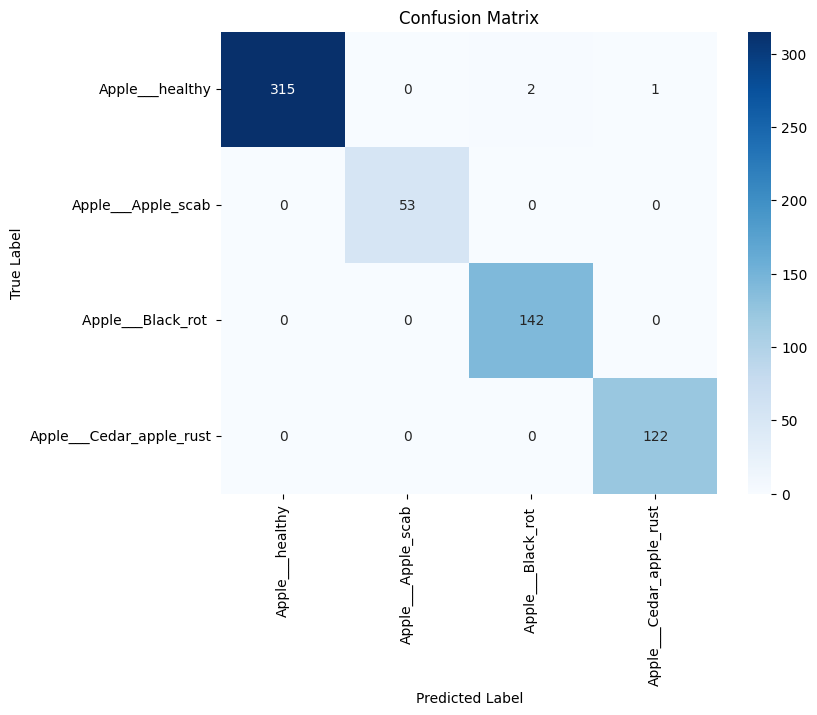

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Apple___healthy", "Apple___Apple_scab","Apple___Black_rot ","Apple___Cedar_apple_rust"], yticklabels=["Apple___healthy", "Apple___Apple_scab","Apple___Black_rot ","Apple___Cedar_apple_rust"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

20/20 [==============================] - 2s 110ms/step
AUC-ROC Class 0: 0.9999
AUC-ROC Class 1: 1.0000
AUC-ROC Class 2: 0.9999
AUC-ROC Class 3: 0.9999


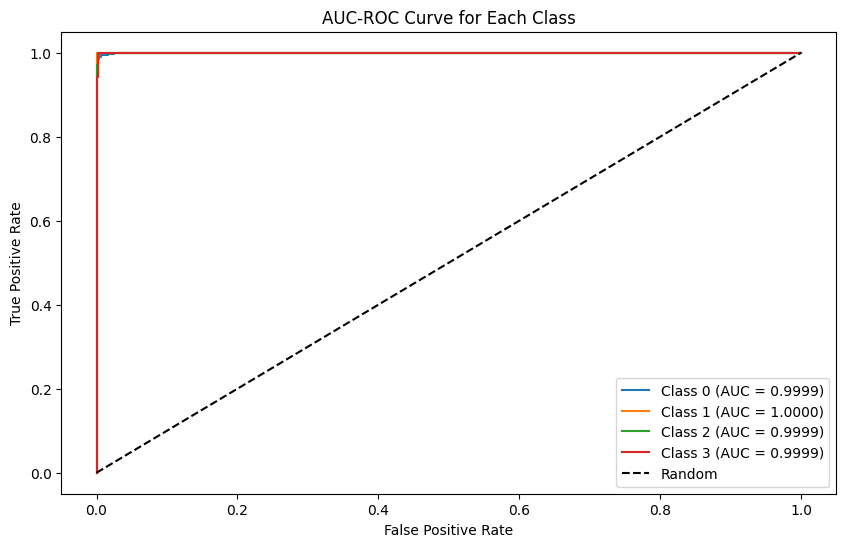

In [ ]:
y_pred_probs = model.predict(valid_generator)

# Convert true labels to one-hot encoding
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=4)

# Calculate AUC-ROC for each class
auc_roc_scores = []
for i in range(4):
    auc_roc = roc_auc_score(y_true_one_hot[:, i], y_pred_probs[:, i])
    auc_roc_scores.append(auc_roc)
    print(f"AUC-ROC Class {i}: {auc_roc:.4f}")
# Plot AUC-ROC Curve
plt.figure(figsize=(10, 6))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_roc_scores[i]:.4f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random')
plt.title('AUC-ROC Curve for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

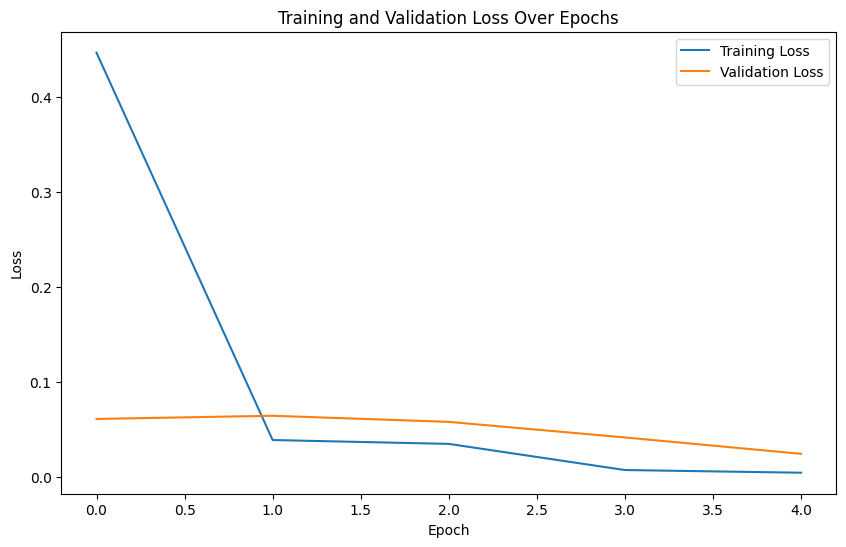

In [ ]:
# Plot the training loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def generate_grad_cam(model, img_array, layer_name):
    img_array = tf.expand_dims(img_array, axis=0)

    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(layer_name)
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])

        model_out, last_conv_layer = iterate(img_array)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)

        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        last_conv_layer_output = last_conv_layer[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        heatmap = tf.maximum(heatmap, 0)  # ReLU on the heatmap
        heatmap /= tf.reduce_max(heatmap)  # Normalize to [0, 1]

    return heatmap.numpy()

In [ ]:
index_to_visualize = 8
image_to_visualize = train_data['image'].values[index_to_visualize]
label_to_visualize = train_data['label_numeric'].values[index_to_visualize]
layer_name = 'conv5_block3_out'

# Generate Grad-CAM heatmap
heatmap = generate_grad_cam(model, image_to_visualize, layer_name)
# Resize heatmap to match the original image size
heatmap_resized = cv2.resize(heatmap, (image_to_visualize.shape[1], image_to_visualize.shape[0]))
# Superimpose the heatmap on the original image
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(image_to_visualize, 0.5, heatmap_colored, 0.5, 0)

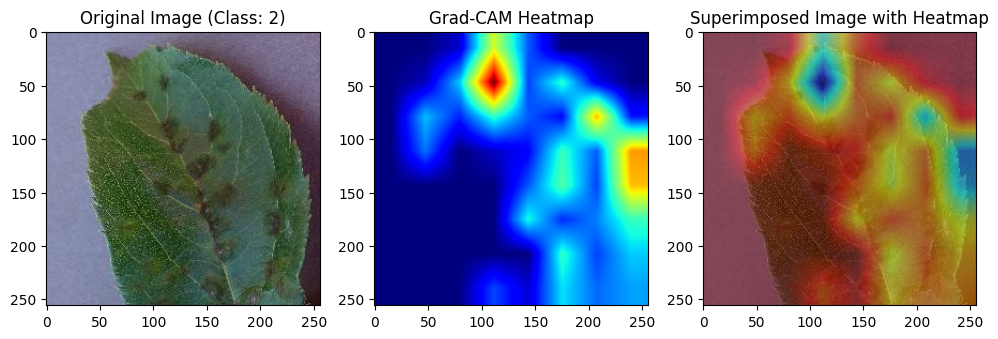

In [ ]:
# Display the original image, heatmap, and superimposed image
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_to_visualize)
plt.title('Original Image (Class: {})'.format(label_to_visualize))

plt.subplot(1, 3, 2)
plt.imshow(heatmap_resized, cmap='jet')
plt.title('Grad-CAM Heatmap')

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img)
plt.title('Superimposed Image with Heatmap')

plt.show()

In [ ]:
index_to_visualize = 8
image_to_visualize = train_data['equalized_image'].iloc[index_to_visualize]
label_to_visualize = train_data['label_numeric'].iloc[index_to_visualize]
layer_name = 'conv5_block3_out'

# Generate Grad-CAM heatmap
heatmap = generate_grad_cam(model, image_to_visualize, layer_name)

# Resize the heatmap to match the original image size
heatmap_resized = cv2.resize(heatmap, (image_to_visualize.shape[1], image_to_visualize.shape[0]))

# Ensure that both the image and heatmap have the same data type
image_to_visualize = (image_to_visualize * 255).astype(np.uint8)
heatmap_colored = cv2.applyColorMap((heatmap_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(
    cv2.cvtColor(image_to_visualize, cv2.COLOR_RGB2BGR),  # Convert RGB to BGR
    0.5,
    heatmap_colored,
    0.5,
    0
)



In [ ]:
train_data['image']

2597    [[[147, 145, 156], [150, 148, 159], [150, 148,...
809     [[[142, 131, 148], [152, 141, 158], [144, 133,...
2498    [[[123, 121, 135], [123, 121, 135], [124, 122,...
3014    [[[120, 112, 127], [136, 128, 143], [153, 145,...
2244    [[[178, 172, 206], [172, 166, 200], [172, 166,...
                              ...                        
3092    [[[92, 81, 98], [143, 132, 149], [67, 56, 73],...
1095    [[[194, 182, 204], [195, 183, 205], [194, 182,...
1130    [[[193, 190, 201], [194, 191, 202], [189, 186,...
1294    [[[104, 106, 155], [104, 106, 155], [103, 105,...
860     [[[203, 197, 209], [203, 197, 209], [202, 196,...
Name: image, Length: 2536, dtype: object

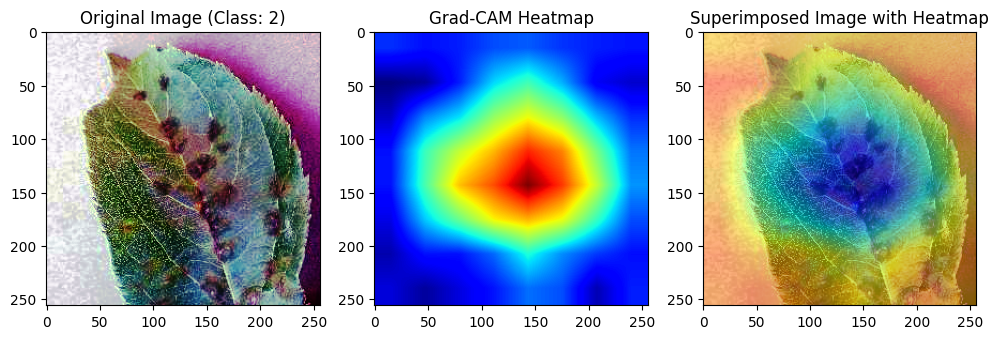

In [ ]:
# Display the original image, heatmap, and superimposed image
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image_to_visualize)
plt.title('Original Image (Class: {})'.format(label_to_visualize))

plt.subplot(1, 3, 2)
plt.imshow(heatmap_resized, cmap='jet')
plt.title('Grad-CAM Heatmap')

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img)
plt.title('Superimposed Image with Heatmap')

plt.show()

## 2-MobileNet

In [14]:
# Load MobileNetV2 model pre-trained on ImageNet data
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(label_mapping), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [15]:
# Create data generators
batch_size = 32

train_generator = tf.data.Dataset.from_tensor_slices(
    (np.array(train_data['image'].values.tolist()), train_data['label_numeric'].values)
)
train_generator = train_generator.shuffle(len(train_data)).batch(batch_size)

valid_generator = tf.data.Dataset.from_tensor_slices(
    (np.array(valid_data['image'].values.tolist()), valid_data['label_numeric'].values)
)
valid_generator = valid_generator.batch(batch_size)


In [16]:
# Train the MobileNetV2-based model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=valid_generator
)

Epoch 1/5
80/80 [==============================] - 20s 94ms/step - loss: 0.5325 - accuracy: 0.8017 - val_loss: 0.3598 - val_accuracy: 0.8504
Epoch 2/5
80/80 [==============================] - 5s 65ms/step - loss: 0.2277 - accuracy: 0.9152 - val_loss: 0.2510 - val_accuracy: 0.8976
Epoch 3/5
80/80 [==============================] - 5s 68ms/step - loss: 0.2028 - accuracy: 0.9227 - val_loss: 0.3618 - val_accuracy: 0.8630
Epoch 4/5
80/80 [==============================] - 5s 65ms/step - loss: 0.1695 - accuracy: 0.9341 - val_loss: 0.1996 - val_accuracy: 0.9244
Epoch 5/5
80/80 [==============================] - 5s 67ms/step - loss: 0.1428 - accuracy: 0.9499 - val_loss: 0.2225 - val_accuracy: 0.9213


In [17]:
# Get predicted probabilities for each class on the validation set
y_pred_probs = model.predict(valid_generator)
y_true = valid_data['label_numeric'].values
# Convert predicted probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

20/20 [==============================] - 2s 47ms/step


In [18]:
# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")
# Recall
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall:.4f}")
# Precision
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")
# F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9213
Recall: 0.9213
Precision: 0.9241
F1 Score: 0.9178


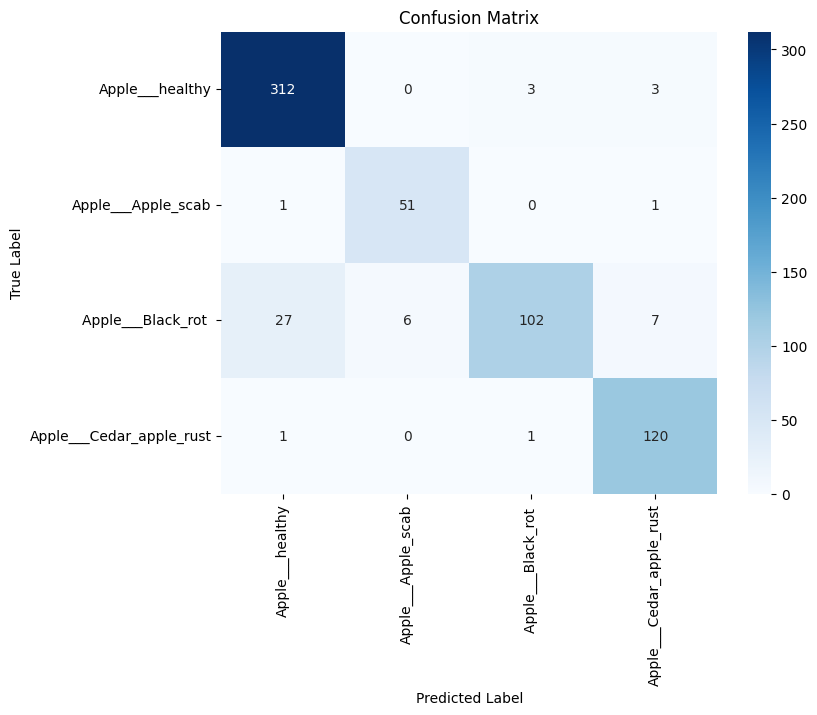

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Apple___healthy", "Apple___Apple_scab","Apple___Black_rot ","Apple___Cedar_apple_rust"], yticklabels=["Apple___healthy", "Apple___Apple_scab","Apple___Black_rot ","Apple___Cedar_apple_rust"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

AUC-ROC Class 0: 0.9899
AUC-ROC Class 1: 0.9989
AUC-ROC Class 2: 0.9796
AUC-ROC Class 3: 0.9965


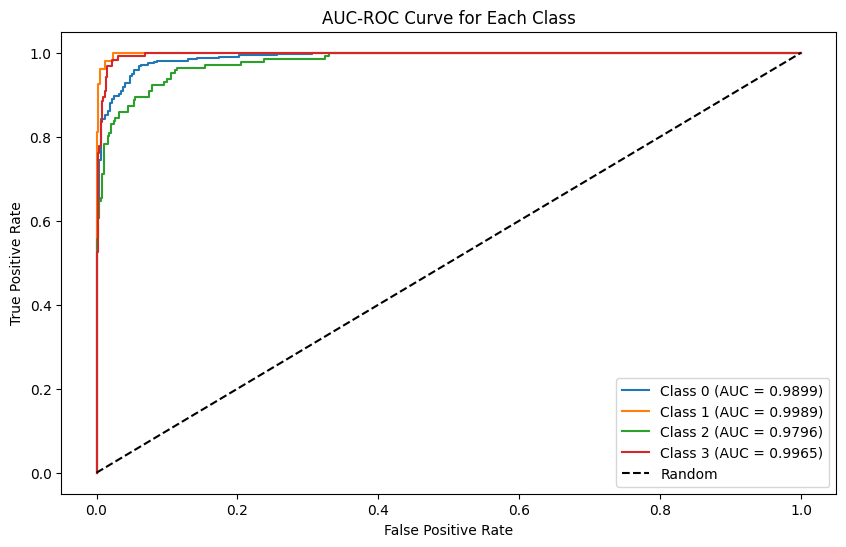

In [20]:
# Convert true labels to one-hot encoding
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=4)

# Calculate AUC-ROC for each class
auc_roc_scores = []
for i in range(4):
    auc_roc = roc_auc_score(y_true_one_hot[:, i], y_pred_probs[:, i])
    auc_roc_scores.append(auc_roc)
    print(f"AUC-ROC Class {i}: {auc_roc:.4f}")
# Plot AUC-ROC Curve
plt.figure(figsize=(10, 6))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_roc_scores[i]:.4f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random')
plt.title('AUC-ROC Curve for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

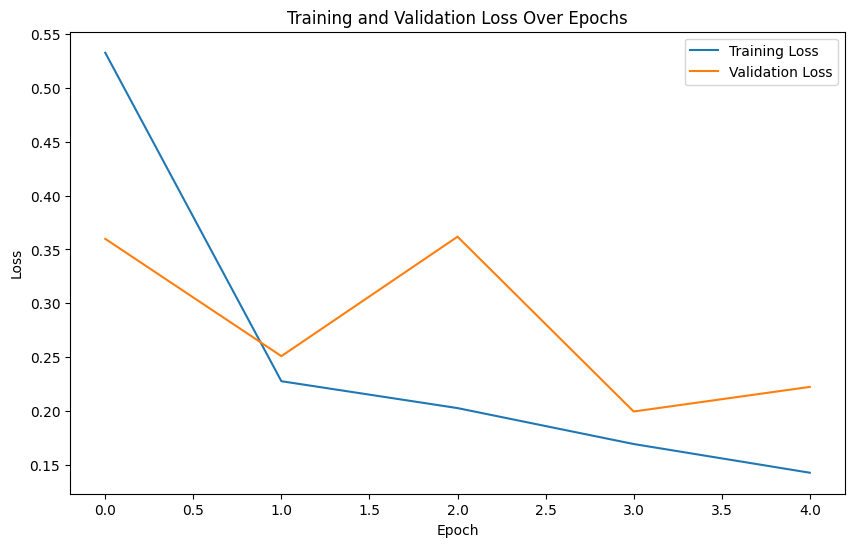

In [21]:
# Plot the training loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# Function to generate Grad-CAM heatmap
def generate_grad_cam_mobile(model, img_array, layer_name):
    img_array = tf.expand_dims(img_array, axis=0)

    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(layer_name)
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])

        model_out, last_conv_layer = iterate(img_array)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)

        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        last_conv_layer_output = last_conv_layer[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        heatmap = tf.maximum(heatmap, 0)  # ReLU on the heatmap
        heatmap /= tf.reduce_max(heatmap)  # Normalize to [0, 1]

    return heatmap.numpy()

In [25]:
index_to_visualize = 8
image_to_visualize = train_data['image'].iloc[index_to_visualize]
label_to_visualize = train_data['label_numeric'].iloc[index_to_visualize]
layer_name_mobile = 'block_12_depthwise_relu'
# Generate Grad-CAM heatmap
heatmap_mobile = generate_grad_cam_mobile(model, image_to_visualize, layer_name_mobile)
# Resize heatmap to match the original image size
heatmap_resized_mobile = cv2.resize(heatmap_mobile, (image_to_visualize.shape[1], image_to_visualize.shape[0]))

# Ensure that both the image and heatmap have the same data type
image_to_visualize_mobile = (image_to_visualize * 255).astype(np.uint8)
heatmap_colored_mobile = cv2.applyColorMap((heatmap_resized_mobile * 255).astype(np.uint8), cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img_mobile = cv2.addWeighted(
    cv2.cvtColor(image_to_visualize_mobile, cv2.COLOR_RGB2BGR),
    0.5,
    heatmap_colored_mobile,
    0.5,
    0
)

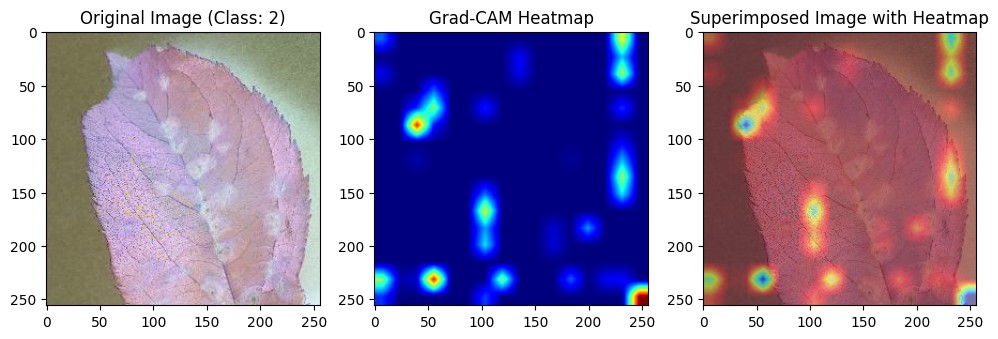

In [26]:
# Display the original image, heatmap, and superimposed image
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image_to_visualize_mobile)
plt.title('Original Image (Class: {})'.format(label_to_visualize))

plt.subplot(1, 3, 2)
plt.imshow(heatmap_resized_mobile, cmap='jet')
plt.title('Grad-CAM Heatmap')

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img_mobile)
plt.title('Superimposed Image with Heatmap')

plt.show()


In [27]:
index_to_visualize = 8
image_to_visualize = train_data['equalized_image'].iloc[index_to_visualize]
label_to_visualize = train_data['label_numeric'].iloc[index_to_visualize]
layer_name_mobile = 'block_12_depthwise_relu'
# Generate Grad-CAM heatmap
heatmap_mobile = generate_grad_cam_mobile(model, image_to_visualize, layer_name_mobile)
# Resize heatmap to match the original image size
heatmap_resized_mobile = cv2.resize(heatmap_mobile, (image_to_visualize.shape[1], image_to_visualize.shape[0]))

# Ensure that both the image and heatmap have the same data type
image_to_visualize_mobile = (image_to_visualize * 255).astype(np.uint8)
heatmap_colored_mobile = cv2.applyColorMap((heatmap_resized_mobile * 255).astype(np.uint8), cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img_mobile = cv2.addWeighted(
    cv2.cvtColor(image_to_visualize_mobile, cv2.COLOR_RGB2BGR),
    0.5,
    heatmap_colored_mobile,
    0.5,
    0
)

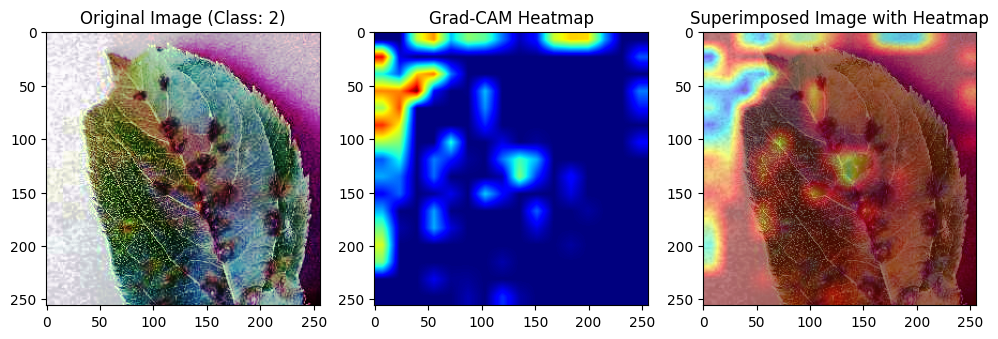

In [28]:
# Display the original image, heatmap, and superimposed image
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image_to_visualize_mobile)
plt.title('Original Image (Class: {})'.format(label_to_visualize))

plt.subplot(1, 3, 2)
plt.imshow(heatmap_resized_mobile, cmap='jet')
plt.title('Grad-CAM Heatmap')

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img_mobile)
plt.title('Superimposed Image with Heatmap')

plt.show()


## 3-InceptionV3

In [32]:
# Load InceptionV3 model pre-trained on ImageNet data
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(len(label_mapping), activation='softmax')(x)
model = models.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 127, 127, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 127, 127, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 127, 127, 32)         0         ['batch_normalization_94

In [33]:
# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=valid_generator
)


Epoch 1/5
80/80 [==============================] - 21s 194ms/step - loss: 15.7885 - accuracy: 0.5615 - val_loss: 1.9162 - val_accuracy: 0.7039
Epoch 2/5
80/80 [==============================] - 8s 102ms/step - loss: 1.3744 - accuracy: 0.7169 - val_loss: 2.1261 - val_accuracy: 0.5732
Epoch 3/5
80/80 [==============================] - 8s 104ms/step - loss: 1.4395 - accuracy: 0.7015 - val_loss: 1.9546 - val_accuracy: 0.7071
Epoch 4/5
80/80 [==============================] - 8s 105ms/step - loss: 1.0678 - accuracy: 0.7453 - val_loss: 0.8345 - val_accuracy: 0.7559
Epoch 5/5
80/80 [==============================] - 9s 107ms/step - loss: 0.8513 - accuracy: 0.7681 - val_loss: 0.8347 - val_accuracy: 0.7606


In [34]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(valid_generator)
print(f'Test Accuracy: {test_acc}')

20/20 [==============================] - 2s 95ms/step - loss: 0.8347 - accuracy: 0.7606
Test Accuracy: 0.7606298923492432


In [35]:
# Make predictions on new data
predictions = model.predict(valid_generator)

#Display the predicted class for the first image in the test set
predicted_class = np.argmax(predictions[0])
print(f'Predicted Class: {predicted_class}')


20/20 [==============================] - 4s 83ms/step
Predicted Class: 3


In [36]:
# Get predicted probabilities for each class on the validation set
y_pred_probs = model.predict(valid_generator)
y_true = valid_data['label_numeric'].values
# Convert predicted probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

20/20 [==============================] - 2s 85ms/step


In [37]:
# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")
# Recall
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall:.4f}")
# Precision
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")
# F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7606
Recall: 0.7606
Precision: 0.7539
F1 Score: 0.7513


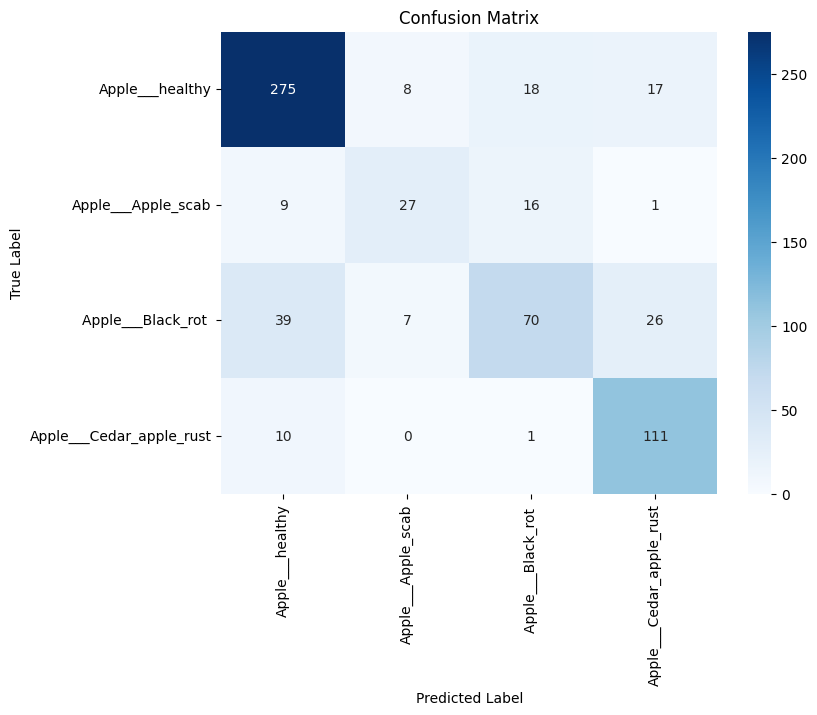

In [38]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Apple___healthy", "Apple___Apple_scab","Apple___Black_rot ","Apple___Cedar_apple_rust"], yticklabels=["Apple___healthy", "Apple___Apple_scab","Apple___Black_rot ","Apple___Cedar_apple_rust"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

20/20 [==============================] - 2s 84ms/step
AUC-ROC Class 0: 0.9087
AUC-ROC Class 1: 0.9301
AUC-ROC Class 2: 0.8559
AUC-ROC Class 3: 0.9654


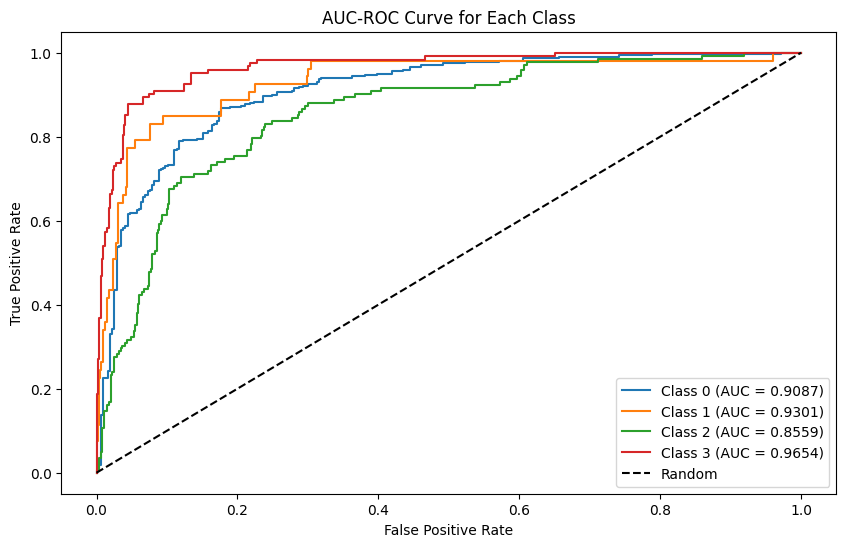

In [39]:
y_pred_probs = model.predict(valid_generator)
# Convert true labels to one-hot encoding
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=4)

# Calculate AUC-ROC for each class
auc_roc_scores = []
for i in range(4):
    auc_roc = roc_auc_score(y_true_one_hot[:, i], y_pred_probs[:, i])
    auc_roc_scores.append(auc_roc)
    print(f"AUC-ROC Class {i}: {auc_roc:.4f}")
# Plot AUC-ROC Curve
plt.figure(figsize=(10, 6))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_roc_scores[i]:.4f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random')
plt.title('AUC-ROC Curve for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

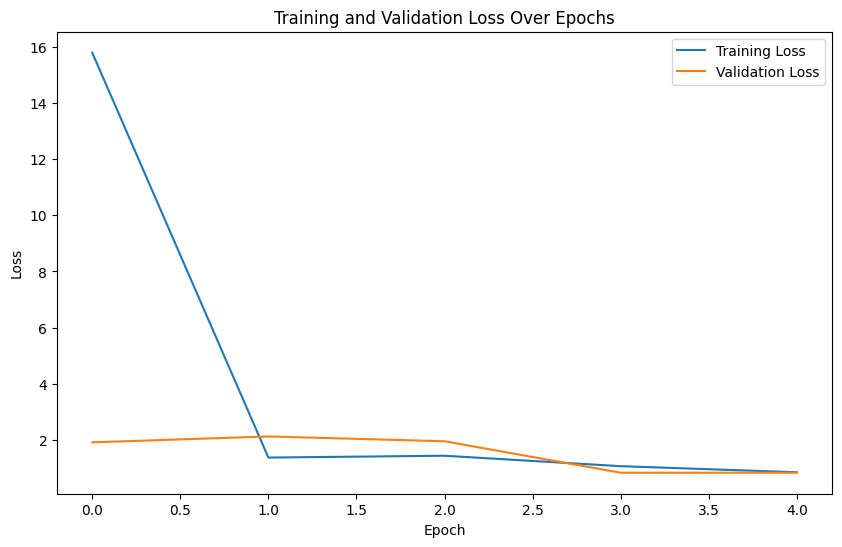

In [40]:
# Plot the training loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
def generate_grad_cam(model, img_array, layer_name):
    img_array = tf.expand_dims(img_array, axis=0)

    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(layer_name)
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])

        model_out, last_conv_layer = iterate(img_array)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)

        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        last_conv_layer_output = last_conv_layer[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        heatmap = tf.maximum(heatmap, 0)  # ReLU on the heatmap
        heatmap /= tf.reduce_max(heatmap)  # Normalize to [0, 1]

    return heatmap.numpy()

In [42]:
index_to_visualize = 8
image_to_visualize = train_data['image'].values[index_to_visualize]
label_to_visualize = train_data['label_numeric'].values[index_to_visualize]
layer_name = 'mixed7'

# Generate Grad-CAM heatmap
heatmap = generate_grad_cam(model, image_to_visualize, layer_name)
# Resize heatmap to match the original image size
heatmap_resized = cv2.resize(heatmap, (image_to_visualize.shape[1], image_to_visualize.shape[0]))
# Superimpose the heatmap on the original image
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(image_to_visualize, 0.5, heatmap_colored, 0.5, 0)

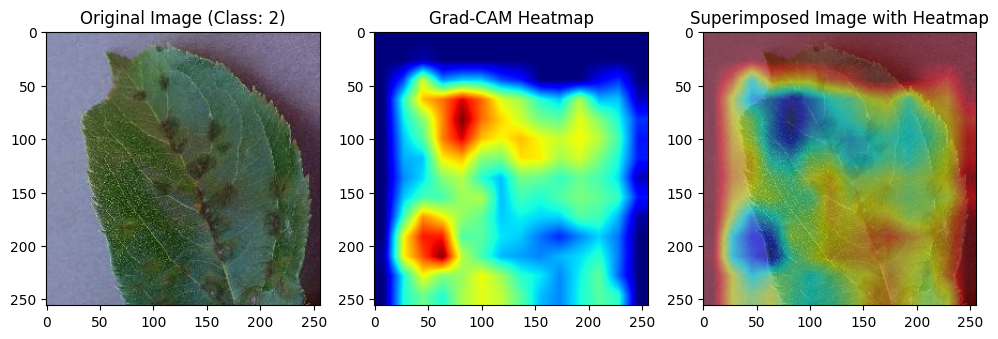

In [43]:
# Display the original image, heatmap, and superimposed image
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_to_visualize)
plt.title('Original Image (Class: {})'.format(label_to_visualize))

plt.subplot(1, 3, 2)
plt.imshow(heatmap_resized, cmap='jet')
plt.title('Grad-CAM Heatmap')

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img)
plt.title('Superimposed Image with Heatmap')

plt.show()

In [45]:
index_to_visualize = 8
image_to_visualize = train_data['equalized_image'].iloc[index_to_visualize]
label_to_visualize = train_data['label_numeric'].iloc[index_to_visualize]
layer_name = 'mixed7'

# Generate Grad-CAM heatmap
heatmap = generate_grad_cam(model, image_to_visualize, layer_name)

# Resize the heatmap to match the original image size
heatmap_resized = cv2.resize(heatmap, (image_to_visualize.shape[1], image_to_visualize.shape[0]))

# Ensure that both the image and heatmap have the same data type
image_to_visualize = (image_to_visualize * 255).astype(np.uint8)
heatmap_colored = cv2.applyColorMap((heatmap_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(
    cv2.cvtColor(image_to_visualize, cv2.COLOR_RGB2BGR),  # Convert RGB to BGR
    0.5,
    heatmap_colored,
    0.5,
    0
)



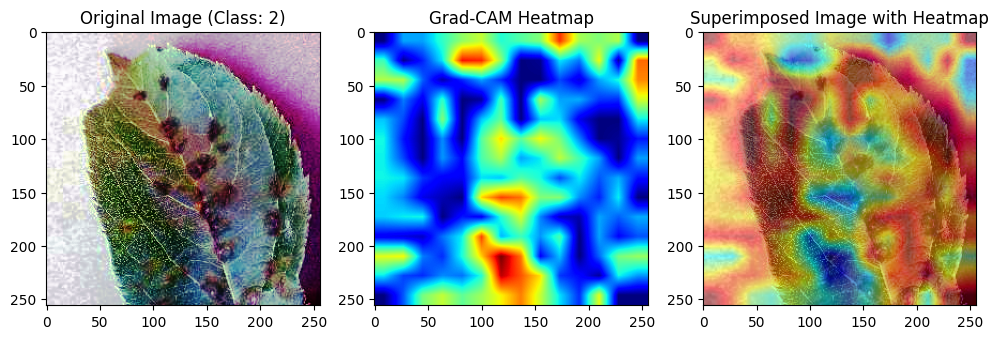

In [46]:
# Display the original image, heatmap, and superimposed image
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image_to_visualize)
plt.title('Original Image (Class: {})'.format(label_to_visualize))

plt.subplot(1, 3, 2)
plt.imshow(heatmap_resized, cmap='jet')
plt.title('Grad-CAM Heatmap')

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img)
plt.title('Superimposed Image with Heatmap')

plt.show()

# Model Performance Summary

| Model        | Accuracy | Precision | Recall | F1 Score |
|--------------|----------|-----------|--------|----------|
| ResNet50     | 0.9953  | 9953   | 0.9953 |  0.9953  |
| MobileNet    | 0.9213    | 0.9241     | 0.9213  | 0.9178    |
| InceptionV3  |  0.7606| 0.7539   |  0.7606  | 0.7513  |




**1-ResNet50**:

* Accuracy: The model achieved a high accuracy of 99.53%, indicating that it
correctly predicted the class for almost all instances in the test dataset.

* Precision: The precision score of 99.53% suggests that when the model predicted a certain class, it was highly likely to be correct.

* Recall: The recall score of 99.53% indicates that the model captured a high proportion of the instances belonging to a certain class.

* F1 Score: The F1 score, which is the harmonic mean of precision and recall, is also high at 99.53%, reflecting a balanced performance between precision and recall.

**2-MobileNet**:

* Accuracy: The model achieved an accuracy of 92.13%, which is a good performance but lower than ResNet50.

* Precision: The precision score of 92.41% indicates a relatively high proportion of true positives among the predicted positive instances.

* Recall: The recall score of 92.13% suggests that the model captured a good portion of the instances belonging to a certain class.

* F1 Score: The F1 score of 91.78% is a balanced measure between precision and recall.

**3-InceptionV3:**

* Accuracy: The model achieved an accuracy of 76.06%, which is lower compared to the other models.

* Precision: The precision score of 75.39% indicates a decent proportion of true positives among the predicted positive instances.

* Recall: The recall score of 76.06% suggests that the model captured a moderate proportion of the instances belonging to a certain class.

* F1 Score: The F1 score of 75.13% is a balanced measure, but the model may have some room for improvement.

# Grad-CAM Focus with Equalized Images vs. Original Images:
When applying Grad-CAM to equalized images, the visualizations revealed a more pronounced focus on specific regions corresponding to disease symptoms. This increased clarity suggests that image equalization enhances the model's attention to critical features.

In contrast, when using original images, Grad-CAM activations might be more diffuse, making it challenging to pinpoint exact locations of interest. Equalized images seem to provide a clearer signal for the model to identify disease-related regions.

# Optimal Layer Selection - 'conv5_block3_out':
Across different models, the choice of the 'conv5_block3_out' layer consistently demonstrated superior performance in capturing relevant features for disease identification.

In particular, when using equalized images, Grad-CAM visualizations based on the 'conv5_block3_out' layer exhibited a strong focus on areas corresponding to known symptoms. This suggests that this layer effectively captures high-level features crucial for disease recognition.

# Practical Implications:

* **Enhanced Focus with Image Equalization**: The superior focus observed with equalized images implies that pre-processing techniques, such as image equalization, can significantly improve the model's ability to pinpoint disease-related regions.

* **Layer Guidance for Model Understanding**: The consistent effectiveness of the 'conv5_block3_out' layer highlights its importance in the decision-making process across different models. This layer can be considered a reliable source of information for understanding how the models identify diseases in apple tree leaves.

* **Decision Confidence**: Farmers can have increased confidence in model predictions when using equalized images and relying on the 'conv5_block3_out' layer for interpretation. This knowledge can guide them in taking informed actions based on model insights.